## PyTorch Computer Vision

* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with PyTorch
* `torch.utils.data.Dataset` - Basse dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu118
0.20.1+cu118


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_data = datasets.FashionMNIST(
    root="data", # Where to download to
    train=True, # If you want the training dataset
    download=True,
    transform=torchvision.transforms.ToTensor(), # how do you want to transform the data
    target_transform=None # how do you want to transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
image, label = train_data[2930]
image.shape

torch.Size([1, 28, 28])

In [8]:
label

4

Text(0.5, 1.0, 'Coat')

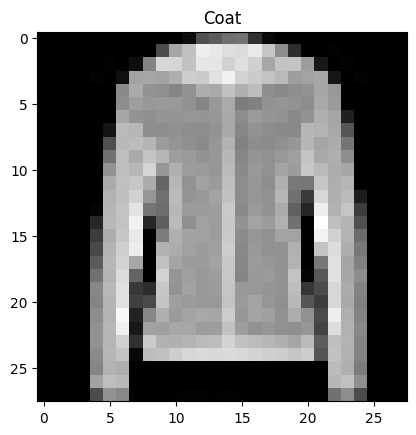

In [9]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

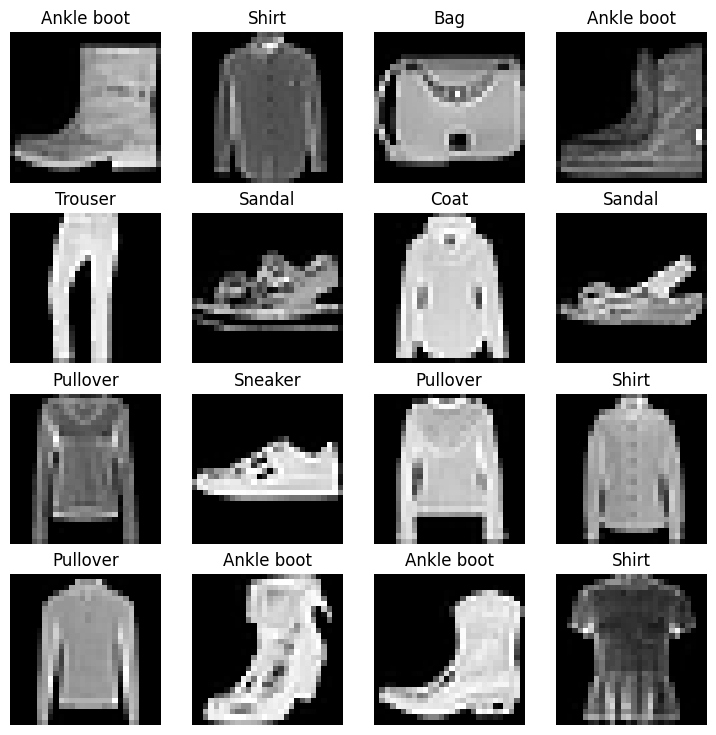

In [10]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [11]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Dataloader

DataLoader turns the dataset into a Python iterable.

More specifically turns the data into batches (or mini-batches)

Why do this ?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60 000 images at once. So it breaks down to smaller chunks at a time.
2. The neural network has more chances to update its gradients per epoch.


In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [13]:
len(train_dataloader), len(train_data), len(train_dataloader) * 32

(1875, 60000, 60000)

In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape # [Batch size, color channel, height, width]

torch.Size([32, 1, 28, 28])

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


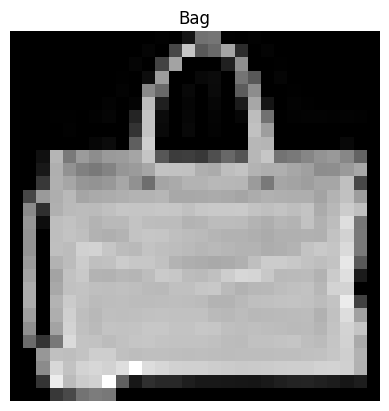

In [15]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Building a baseline model

In [16]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [17]:
from torch import nn
class FashionMNISTModelv0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [18]:
torch.manual_seed(42)

model_0 = FashionMNISTModelv0(
    input_shape=784, # 28 * 28
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_0

FashionMNISTModelv0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [19]:
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
model_0(dummy_x).shape

torch.Size([1, 10])

## Loss, optimizer and evaluation metrics

* Loss function - multi-class data, the loss function will be `nn.CrossEntropyLoss()`
* Optimizer - Stochastic gradient descent `torch.optim.SGD()`

In [20]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists


In [21]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [22]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## Training loop

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss, per batch


In [23]:
!pip install tqdm


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters())))


C:\Users\archb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|████████████████████████████                                                        | 1/3 [00:04<00:08,  4.34s/it]


Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:08<00:04,  4.41s/it]


Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.35s/it]


Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on Parameter containing:
tensor([[ 0.0273,  0.0298, -0.0065,  ...,  0.0071,  0.0091,  0.0170],
        [-0.0189, -0.0355,  0.0155,  ...,  0.0161,  0.0120,  0.0117],
        [-0.0008,  0.0020,  0.0032,  ...,  0.0058, -0.0146,  0.0084],
        ...,
        [-0.0116,  0.0274, -0.0323,  ...,  0.0527,  0.0434,  0.0006],
        [-0.0231,  0.0252,  0.0236,  ..., -0.0892, -0.0385, -0.0071],
        [ 0.0175, -0.0148,  0.0027,  ..., -0.1155, -0.0674,  0.0125]],
       device='cuda:0', requires_grad=True): 13.052 seconds


## Making predictions and getting results

In [25]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """ Returns a dictionary containing the results of model p[redicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
        #Device agnostic data
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss += loss_fn(y_pred, y)
        acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # Only work with class models
          "model_loss": loss.item(),
          "model_acc": acc}

In [26]:
model_0_results = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMNISTModelv0',
 'model_loss': 0.4766389727592468,
 'model_acc': 83.42651757188499}

## Creating a model with non-linearity


In [27]:
class FashionMNISTModelv1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [28]:
torch.manual_seed(42)
model_1 = FashionMNISTModelv1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelv1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [29]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

## Functionizing training and evaluation/testing loops

* Training loop - `train_step()`
* Testing loop - `test_step()`

In [30]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
    """Performs a training with model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0
    model.train()
    
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)            
        #Forward pass
        y_pred = model(X)

        # Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # logits -> prediction labels

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.4f}")

In [31]:
def test_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):
    """Performs a testing loop on model going over data_loader."""
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Forward pass
            test_pred = model(X)

            # Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        test_loss /= len(data_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(data_loader)

    ## Print out what's happening
    print(f"\nTest loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

In [32]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 5

for epoch in range(epochs):
    print(f"Epoch: {epoch} \n -------------")
    train_step(model=model_1,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=device)

Epoch: 0 
 -------------
Train loss: 1.09199 | Train acc: 61.3433

Test loss: 0.95636 | Test acc: 65.00
Epoch: 1 
 -------------
Train loss: 0.78101 | Train acc: 71.9283

Test loss: 0.72227 | Test acc: 73.91
Epoch: 2 
 -------------
Train loss: 0.67027 | Train acc: 75.9367

Test loss: 0.68500 | Test acc: 75.02
Epoch: 3 
 -------------
Train loss: 0.64384 | Train acc: 76.5233

Test loss: 0.65079 | Test acc: 76.13
Epoch: 4 
 -------------
Train loss: 0.62892 | Train acc: 77.0017

Test loss: 0.65277 | Test acc: 75.95
Train time on cuda: 24.386 seconds


**Note:** Sometimes, depending on data/hardware your model might train faster on CPU than GPU

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. The hardware you're using has a better CPU in terms compute capability than the GPU.

In [33]:
model_1_results = eval_model(model=model_1,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelv1',
 'model_loss': 0.6527654528617859,
 'model_acc': 75.94848242811501}

## Building a Convolutional Neural Network (CNN)

In [34]:
class FashionMNISTModelv2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1), # Hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                     out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [35]:
torch.manual_seed(42)
model_2 = FashionMNISTModelv2(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelv2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [36]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Looking into `nn.Conv2d()`

In [37]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Image shape: {test_image.shape}")
print(f"Image: \n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Image shape: torch.Size([3, 64, 64])
Image: 
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978,  1.0

In [38]:
conv_layer = nn.Conv2d(in_channels=3, 
                      out_channels=10,
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1)

conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 64, 64])

In [39]:
max_pool2d = nn.MaxPool2d(kernel_size=2)
max_pool2d(test_image).shape, test_image.shape

(torch.Size([3, 32, 32]), torch.Size([3, 64, 64]))

In [40]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 1, 2, 2))
max_pool_layer = nn.MaxPool2d(kernel_size=2)
print(f"Max pool tensor: \n {max_pool_layer(random_tensor)} \n")
print(f"Max pool tensor shape: {max_pool_layer(random_tensor).shape}")
print(f"Random tensor shape before max pooling: {random_tensor.shape}\n")
print(f"Random tensor before max pooling: \n {random_tensor}")

Max pool tensor: 
 tensor([[[[0.3367]]]]) 

Max pool tensor shape: torch.Size([1, 1, 1, 1])
Random tensor shape before max pooling: torch.Size([1, 1, 2, 2])

Random tensor before max pooling: 
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])


## Loss function and optimizer for `model_2`

In [41]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [42]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n --------------")
    train_step(model=model_2,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_2,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                            device=device)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0 
 --------------
Train loss: 0.59126 | Train acc: 78.5233


 20%|████████████████▊                                                                   | 1/5 [00:07<00:30,  7.57s/it]


Test loss: 0.39828 | Test acc: 85.97
Epoch: 1 
 --------------
Train loss: 0.36154 | Train acc: 86.9517


 40%|█████████████████████████████████▌                                                  | 2/5 [00:15<00:23,  7.78s/it]


Test loss: 0.34628 | Test acc: 87.14
Epoch: 2 
 --------------
Train loss: 0.32284 | Train acc: 88.1950


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:22<00:14,  7.33s/it]


Test loss: 0.35052 | Test acc: 87.57
Epoch: 3 
 --------------
Train loss: 0.30240 | Train acc: 89.1150


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:30<00:07,  7.49s/it]


Test loss: 0.31675 | Test acc: 88.23
Epoch: 4 
 --------------
Train loss: 0.29056 | Train acc: 89.4600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.29s/it]


Test loss: 0.30055 | Test acc: 89.41
Train time on cuda: 36.472 seconds


In [44]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

{'model_name': 'FashionMNISTModelv2',
 'model_loss': 0.30055463314056396,
 'model_acc': 89.40694888178913}

In [45]:
model_0_results

{'model_name': 'FashionMNISTModelv0',
 'model_loss': 0.4766389727592468,
 'model_acc': 83.42651757188499}

In [46]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results,
                              model_1_results,
                              model_2_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelv0,0.476639,83.426518
1,FashionMNISTModelv1,0.652765,75.948482
2,FashionMNISTModelv2,0.300555,89.406949


In [47]:
# Adding training time to results comparison
compare_results["training_time"] = [total_train_time_model_0, 
                                   total_train_time_model_1, 
                                   total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelv0,0.476639,83.426518,13.051730
1,FashionMNISTModelv1,0.652765,75.948482,24.386493
2,FashionMNISTModelv2,0.300555,89.406949,36.472387


Text(0, 0.5, 'model')

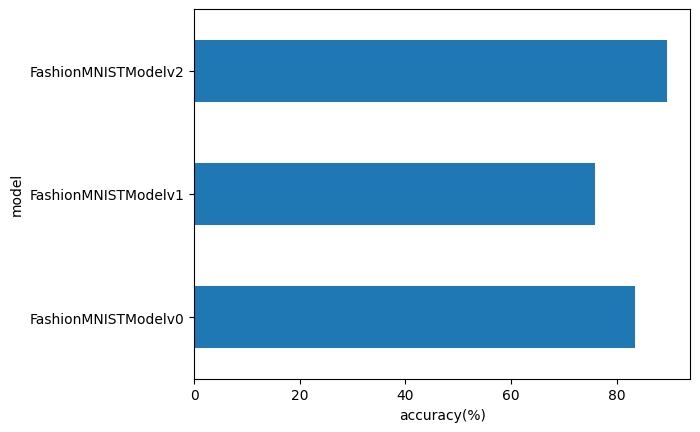

In [48]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model")

In [49]:
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
    pred_probs = []
    model.to(device) 
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            #Forward pass
            pred_logit = model(sample)
            # Prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())
    # Stack pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [50]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

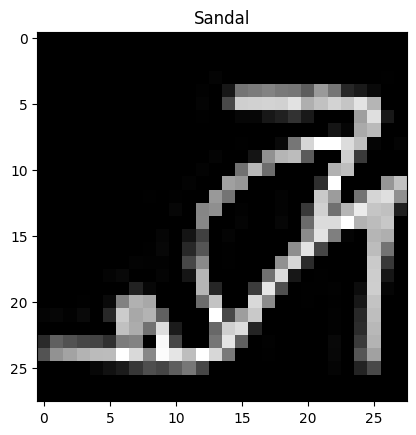

In [51]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [52]:
pred_probs = make_predictions(model=model_2,data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

In [53]:
test_labels

[5, 4, 1, 2, 2, 2, 7, 1, 0]

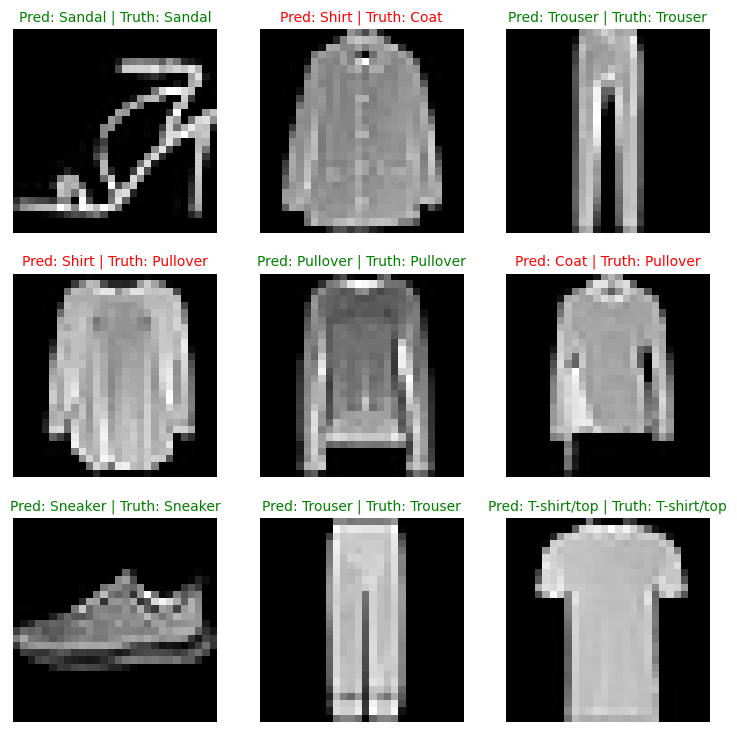

In [54]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    #Finding predictions
    pred_label = class_names[pred_classes[i]]
    # Get the truth label 
    truth_label = class_names[test_labels[i]]
    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)

## Making a confusion matrix for further prediction evaluation

In [55]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
    
        y_logit = model_2(X)
    
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    
        y_preds.append(y_pred.cpu())

    #Concatenate list of predictions into a tensor
    print(y_preds)
    y_pred_tensor = torch.cat(y_preds)
    y_pred_tensor[:10]

Making predictions...: 100%|████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 366.03it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 3, 2, 6, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 6, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 6, 7, 6, 7, 2, 3, 2, 2, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 1, 3, 3, 7, 8, 7, 0, 2, 6, 4, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 8]), tensor([6, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 6, 5, 2, 8, 6, 7, 6,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 5, 4, 1, 9, 4, 8, 6, 6, 1, 2, 5, 1, 6, 0, 0, 4, 6, 1, 3, 2, 2, 3, 4,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([7, 2, 3, 8, 0, 9, 4, 8, 4, 8, 6, 5, 4, 1, 2, 8, 3, 6, 9, 1, 0, 9, 3, 6,
        7, 8, 8, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 6, 2, 9, 2, 4, 6, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 4, 5, 4, 9, 2, 2, 8, 6, 4,
        3, 4, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 6, 6, 2, 3, 0, 8, 3, 7, 4,
       

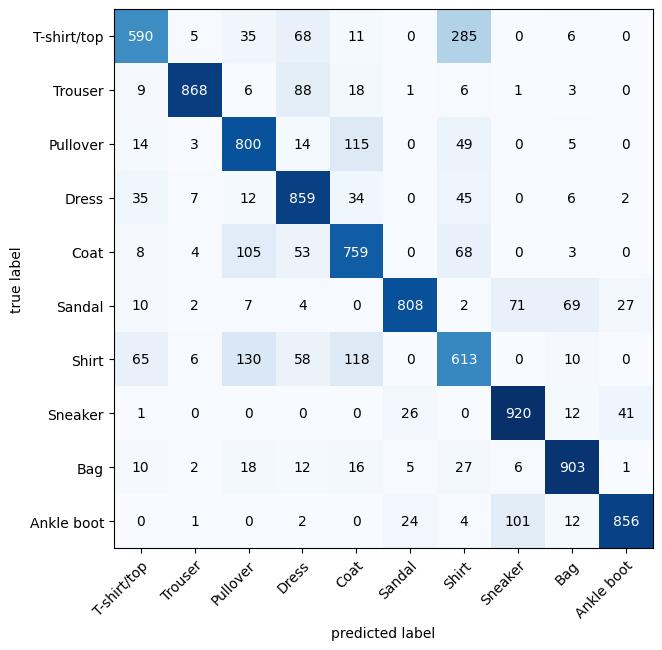

In [60]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## Saving and loading model

In [62]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)

MODEL_NAME = "pytorch_computer_vision_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
          f=MODEL_SAVE_PATH)

Saving model to: models\pytorch_computer_vision_model.pth


In [63]:
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelv2(input_shape=1,
                                    hidden_units=10,
                                    output_shape=len(class_names))

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)

C:\Users\archb\AppData\Local\Temp\ipykernel_24064\2154294624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH)

FashionMNISTModelv2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [64]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelv2',
 'model_loss': 0.30055463314056396,
 'model_acc': 89.40694888178913}